In [1]:
from torch.nn import CrossEntropyLoss

import CNN_lib as lib
import utils as ut
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt

from torchsummary import summary


In [2]:
device= lib.use_GPU()

CUDA is available!  Training on GPU ...
cuda:0


In [3]:
# Define data transformation pipeline
transform = transforms.Compose([
    # Convert PIL images to PyTorch tensors
    transforms.ToTensor(),
    # Normalize pixel values
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Create data loader for training data with batch size 4 and shuffling
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

# Load the CIFAR-10 testing dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

# Create data loader for testing data with batch size 1 and shuffling
testloader = torch.utils.data.DataLoader(testset, batch_size=1,
                                         shuffle=True, num_workers=2)

# Define class labels for CIFAR-10 dataset
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
import seaborn as sns

sns.set_palette('Set2')

def plot_losses(train_loss,test_loss, acc = None):
    fig = plt.figure(figsize=(8,6))
    x = np.arange(1,np.shape(train_loss)[0]+1)
    plt.plot(x,train_loss, label = 'training loss')
    plt.plot(x,test_loss, label = 'test loss')
    plt.title('Training and test loss', fontsize = 18)
    plt.xlabel('epochs')
    plt.xticks(np.arange(1, len(x)+1))
    plt.ylabel('loss')
    plt.legend()
    plt.grid(alpha = 0.3)
    plt.show(fig)
    if acc is not None:
        fig2 = plt.figure(figsize=(8,6))
        plt.title("Accuracy on test set", fontsize = 18)
        plt.plot(x,acc)
        plt.xlabel('epochs')
        plt.xticks(np.arange(1, len(x)+1))
        plt.hlines(xmin = 0,xmax = x[-1],y=np.max(acc), alpha =0.1, colors = 'red')
        plt.ylabel('accuracy')
        plt.grid(alpha = 0.3)
        plt.show()
    
    return

In [60]:
stdnet = lib.StandardNet()
#torch.load('net1.pth')
stdnet.to(device)
summary(stdnet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
         MaxPool2d-2            [-1, 6, 14, 14]               0
            Conv2d-3           [-1, 16, 10, 10]           2,416
         MaxPool2d-4             [-1, 16, 5, 5]               0
            Linear-5                  [-1, 120]          48,120
            Linear-6                   [-1, 84]          10,164
            Linear-7                   [-1, 10]             850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.06
Params size (MB): 0.24
Estimated Total Size (MB): 0.31
----------------------------------------------------------------


In [61]:
net1,train_loss, test_loss, acc = lib.train_net(Net = stdnet, trainloader = trainloader, testloader = testloader, epochs = 15, momentum = 0.9 ,criterion = nn.CrossEntropyLoss())

[epoch: 1] train loss: 1.6849 test loss: 1.3327,test accuracy: 52.2 %
[epoch: 2] train loss: 1.2986 test loss: 1.2088,test accuracy: 57.0 %
[epoch: 3] train loss: 1.1761 test loss: 1.2055,test accuracy: 58.2 %
[epoch: 4] train loss: 1.0992 test loss: 1.2083,test accuracy: 57.8 %
[epoch: 5] train loss: 1.0419 test loss: 1.1609,test accuracy: 59.3 %
[epoch: 6] train loss: 0.9932 test loss: 1.1169,test accuracy: 61.2 %
[epoch: 7] train loss: 0.9547 test loss: 1.1285,test accuracy: 61.7 %
[epoch: 8] train loss: 0.9234 test loss: 1.1277,test accuracy: 61.9 %
[epoch: 9] train loss: 0.8985 test loss: 1.2066,test accuracy: 60.2 %
[epoch: 10] train loss: 0.8813 test loss: 1.2049,test accuracy: 60.2 %
[epoch: 11] train loss: 0.8615 test loss: 1.2041,test accuracy: 60.7 %
[epoch: 12] train loss: 0.8430 test loss: 1.2271,test accuracy: 61.6 %
[epoch: 13] train loss: 0.8201 test loss: 1.2282,test accuracy: 60.3 %
[epoch: 14] train loss: 0.8059 test loss: 1.2357,test accuracy: 61.4 %
[epoch: 15] tra

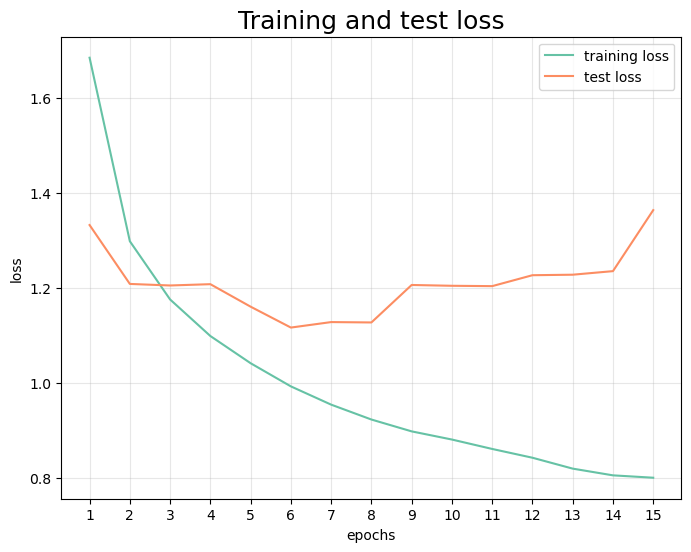

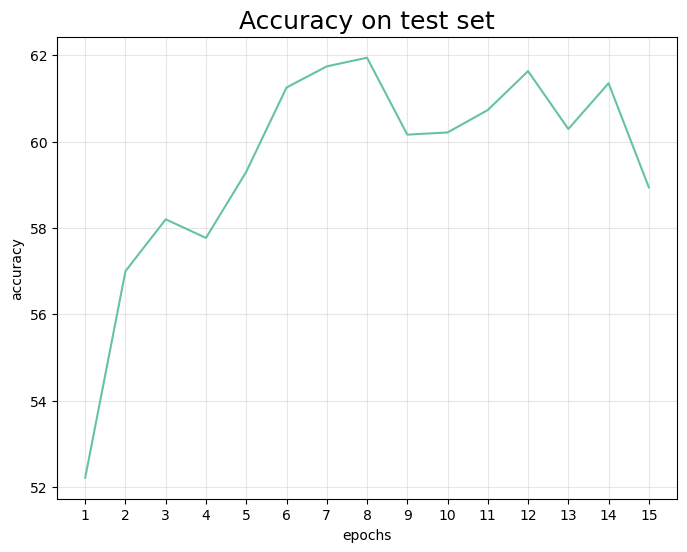

In [73]:
plot_losses(train_loss,test_loss,acc)

In [5]:
class Conv3DropNet(nn.Module):
    """
    This class defines a simple convolutional neural network (CNN) architecture
    for image classification.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer with 3 input channels (RGB),
                           6 output channels, and a kernel size of 5x5.
        pool (nn.MaxPool2d): Max pooling layer with a kernel size of 2x2.
        conv2 (nn.Conv2d): Second convolutional layer with 6 input channels
                           (from the first conv layer), 16 output channels,
                           and a kernel size of 5x5.
        fc1 (nn.Linear): First fully-connected layer that flattens the input
                         from the previous convolutional layers and has 120 neurons.
        fc2 (nn.Linear): Second fully-connected layer with 84 neurons.
        fc3 (nn.Linear): Output layer with 10 neurons, corresponding to the 10 classes
                         in CIFAR-10.

    Methods:
        forward(self, x): Defines the forward pass of the network.
    """
    
    
    def __init__(self):
        super(Conv3DropNet, self).__init__()  # Call the superclass constructor
        self.conv1 = nn.Conv2d(3, 32, 3)  # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.conv2 = nn.Conv2d(32, 64, 3)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 64, 3)  # First convolutional layer
        
        self.dropout= nn.Dropout(0.25)
      
        self.fc1 = nn.Linear(64 * 2 * 2, 128)  # First fully-connected layer
        self.fc2 = nn.Linear(128, 96)  # Second fully-connected layer
        self.fc3 = nn.Linear(96, 84)
        self.fc4 = nn.Linear(84, 10)  # Output layer
   
    def forward(self, x):
        """"
        Defines the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor representing the images.

        Returns:
            torch.Tensor: Output tensor representing the class probabilities.
        """
        x = self.pool(F.relu(self.conv1(x)))  # First convolutional layer with ReLU activation and pooling
        x = self.pool(F.relu(self.conv2(x)))  # Second convolutional layer with ReLU activation and pooling
        x = self.pool(F.relu(self.conv3(x)))  # Third convolutional layer with ReLU activation and pooling
      
        # print(x.shape)
       
        x = x.view(x.shape[0],-1)  # Flatten the output from convolutional layers
        # print(x.shape)
        x = F.leaky_relu_(self.fc1(x))  # First fully-connected layer with ReLU activation
        x = self.dropout(x)
        x = F.leaky_relu_(self.fc2(x))  # Second fully-connected layer with ReLU activation
        x = self.dropout(x)
        x = F.leaky_relu_(self.fc3(x))
        x = self.fc4(x)  # Output layer
      
        return x
    

In [6]:
netDrop = Conv3DropNet()
netDrop.to(device)

summary(netDrop,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             896
         MaxPool2d-2           [-1, 32, 15, 15]               0
            Conv2d-3           [-1, 64, 13, 13]          18,496
         MaxPool2d-4             [-1, 64, 6, 6]               0
            Conv2d-5             [-1, 64, 4, 4]          36,928
         MaxPool2d-6             [-1, 64, 2, 2]               0
            Linear-7                  [-1, 128]          32,896
           Dropout-8                  [-1, 128]               0
            Linear-9                   [-1, 96]          12,384
          Dropout-10                   [-1, 96]               0
           Linear-11                   [-1, 84]           8,148
           Linear-12                   [-1, 10]             850
Total params: 110,598
Trainable params: 110,598
Non-trainable params: 0
-------------------------------

In [8]:
dropnet,train_loss, test_loss, acc = lib.train_net(Net = netDrop, trainloader = trainloader, testloader = testloader, learning_rate=0.001, momentum = 0.9,  epochs = 15, criterion = nn.CrossEntropyLoss())


[epoch: 1] train loss: 1.5645 test loss: 1.3483,test accuracy: 50.0 %
[epoch: 2] train loss: 1.2511 test loss: 1.1404,test accuracy: 59.2 %
[epoch: 3] train loss: 1.0812 test loss: 1.0115,test accuracy: 64.5 %
[epoch: 4] train loss: 0.9646 test loss: 0.9148,test accuracy: 68.0 %
[epoch: 5] train loss: 0.8856 test loss: 0.9189,test accuracy: 68.6 %
[epoch: 6] train loss: 0.8272 test loss: 0.8928,test accuracy: 69.5 %
[epoch: 7] train loss: 0.7714 test loss: 0.8639,test accuracy: 70.8 %
[epoch: 8] train loss: 0.7344 test loss: 0.8038,test accuracy: 72.4 %
[epoch: 9] train loss: 0.6951 test loss: 0.8228,test accuracy: 72.4 %
[epoch: 10] train loss: 0.6641 test loss: 0.8269,test accuracy: 72.3 %
[epoch: 11] train loss: 0.6376 test loss: 0.8513,test accuracy: 71.0 %
[epoch: 12] train loss: 0.6113 test loss: 0.8139,test accuracy: 73.8 %
[epoch: 13] train loss: 0.5863 test loss: 0.8509,test accuracy: 72.3 %
[epoch: 14] train loss: 0.5628 test loss: 0.8146,test accuracy: 73.7 %
[epoch: 15] tra

In [9]:
dropnet2,train_loss2, test_loss2, acc2 = lib.train_net(Net = netDrop, trainloader = trainloader, testloader = testloader, learning_rate=0.001, momentum = 0.9,  epochs = 5, criterion = nn.CrossEntropyLoss())


[epoch: 1] train loss: 0.5325 test loss: 0.8126,test accuracy: 73.5 %
[epoch: 2] train loss: 0.5174 test loss: 0.8222,test accuracy: 73.9 %
[epoch: 3] train loss: 0.5038 test loss: 0.8204,test accuracy: 74.3 %
[epoch: 4] train loss: 0.4850 test loss: 0.8738,test accuracy: 73.2 %
[epoch: 5] train loss: 0.4722 test loss: 0.8690,test accuracy: 72.9 %
Finished Training


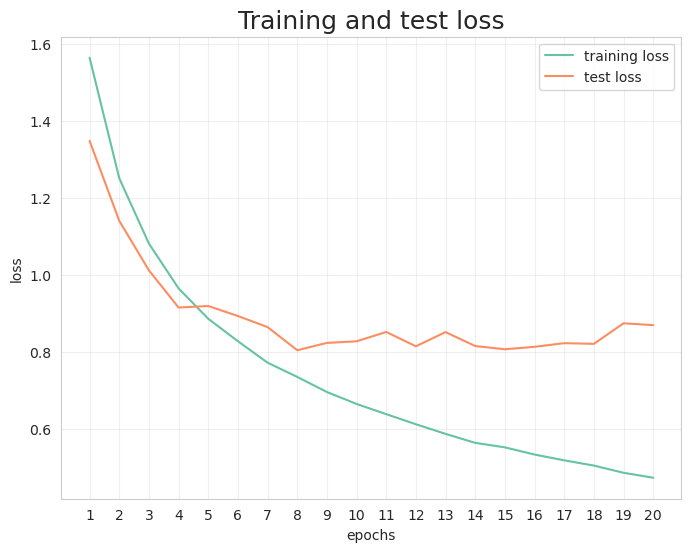

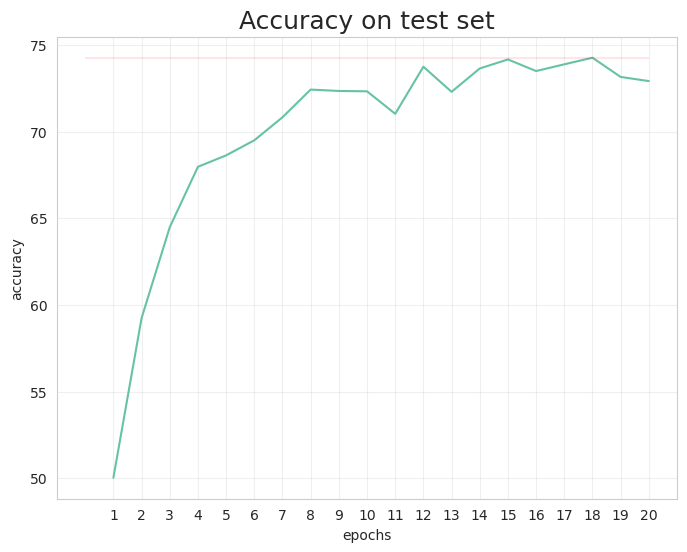

In [24]:
plot_losses(train_loss+ train_loss2,test_loss + test_loss2,acc+acc2)

In [14]:
acc[1]

59.24

In [9]:
class Conv5Net(nn.Module):
    """
    This class defines a simple convolutional neural network (CNN) architecture
    for image classification.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer with 3 input channels (RGB),
                           6 output channels, and a kernel size of 5x5.
        pool (nn.MaxPool2d): Max pooling layer with a kernel size of 2x2.
        conv2 (nn.Conv2d): Second convolutional layer with 6 input channels
                           (from the first conv layer), 16 output channels,
                           and a kernel size of 5x5.
        fc1 (nn.Linear): First fully-connected layer that flattens the input
                         from the previous convolutional layers and has 120 neurons.
        fc2 (nn.Linear): Second fully-connected layer with 84 neurons.
        fc3 (nn.Linear): Output layer with 10 neurons, corresponding to the 10 classes
                         in CIFAR-10.

    Methods:
        forward(self, x): Defines the forward pass of the network.
    """
    
    
    def __init__(self):
        super(Conv5Net, self).__init__()  # Call the superclass constructor
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # First convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)  # Second convolutional layer
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  # First convolutional layer
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Second convolutional layer
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)  # First convolutional layer
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        self.bn5 = nn.BatchNorm2d(256)
        
        
        self.dropout = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256* 4 * 4, 512)  # First fully-connected layer
        self.fc2 = nn.Linear(512, 128)  # Second fully-connected layer
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 10)  # Output layer
   
    def forward(self, x):
        """"
        Defines the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor representing the images.

        Returns:
            torch.Tensor: Output tensor representing the class probabilities.
        """
        x = self.bn1(F.relu(self.conv1(x)))
        x = self.bn2(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = self.bn3(F.relu(self.conv3(x)))  
        x = self.pool(x)
        x = self.bn4(F.relu(self.conv4(x)))
        x = self.bn5(F.relu(self.conv5(x)) ) 
        x = self.pool(x)
        
        # print(x.shape)
       
        x = x.view(x.shape[0],-1)  # Flatten the output from convolutional layers
        # print(x.shape)
        x = self.dropout2(x)
        x = F.gelu(self.fc1(x))  
        x = self.dropout(x)
        x = F.gelu(self.fc2(x))  
        x = self.dropout(x)
        x = F.gelu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)  # Output layer
      
        return x
    

In [10]:
net5conv = Conv5Net()
net5conv.to(device)

summary(net5conv,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
       BatchNorm2d-4           [-1, 64, 32, 32]             128
         MaxPool2d-5           [-1, 64, 16, 16]               0
            Conv2d-6          [-1, 128, 16, 16]          73,856
       BatchNorm2d-7          [-1, 128, 16, 16]             256
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
           Conv2d-11            [-1, 256, 8, 8]         590,080
      BatchNorm2d-12            [-1, 256, 8, 8]             512
        MaxPool2d-13            [-1, 256, 4, 4]               0
          Dropout-14                 [-

In [11]:
net5conv1,train_loss, test_loss, acc = lib.train_net(Net = net5conv, trainloader = trainloader, testloader = testloader,  learning_rate=0.001, momentum=0.8, epochs = 15, criterion = nn.CrossEntropyLoss())

[epoch: 1] train loss: 1.4727 test loss: 0.9989,test accuracy: 66.2 %
[epoch: 2] train loss: 0.9792 test loss: 0.7684,test accuracy: 73.9 %
[epoch: 3] train loss: 0.7935 test loss: 0.6718,test accuracy: 77.6 %
[epoch: 4] train loss: 0.6782 test loss: 0.6201,test accuracy: 79.3 %
[epoch: 5] train loss: 0.5955 test loss: 0.6170,test accuracy: 79.7 %
[epoch: 6] train loss: 0.5212 test loss: 0.5502,test accuracy: 82.0 %
[epoch: 7] train loss: 0.4686 test loss: 0.5440,test accuracy: 82.2 %
[epoch: 8] train loss: 0.4177 test loss: 0.5424,test accuracy: 82.2 %
[epoch: 9] train loss: 0.3774 test loss: 0.5419,test accuracy: 83.0 %
[epoch: 10] train loss: 0.3422 test loss: 0.5204,test accuracy: 83.8 %
[epoch: 11] train loss: 0.3098 test loss: 0.5485,test accuracy: 82.9 %
[epoch: 12] train loss: 0.2853 test loss: 0.5157,test accuracy: 84.0 %
[epoch: 13] train loss: 0.2644 test loss: 0.5197,test accuracy: 84.1 %
[epoch: 14] train loss: 0.2401 test loss: 0.5549,test accuracy: 84.0 %
[epoch: 15] tra

In [14]:
net5conv2,train_loss2, test_loss2, acc2 = lib.train_net(Net = net5conv, trainloader = trainloader, testloader = testloader,  learning_rate=0.001, momentum=0.8, epochs = 5, criterion = nn.CrossEntropyLoss())

[epoch: 1] train loss: 0.1992 test loss: 0.5538,test accuracy: 84.2 %
[epoch: 2] train loss: 0.1847 test loss: 0.5641,test accuracy: 83.9 %
[epoch: 3] train loss: 0.1739 test loss: 0.5814,test accuracy: 84.3 %
[epoch: 4] train loss: 0.1617 test loss: 0.5963,test accuracy: 84.8 %
[epoch: 5] train loss: 0.1512 test loss: 0.5615,test accuracy: 84.6 %
Finished Training


In [ ]:
net5conv3,train_loss3, test_loss3, acc3 = lib.train_net(Net = net5conv, trainloader = trainloader, testloader = testloader,  learning_rate=0.001, momentum=0.8, epochs = 5, criterion = nn.CrossEntropyLoss())


In [9]:
torch.save(net5conv.state_dict(),"net5conv.pth")

In [7]:
net = Conv5Net()
net.state_dict =  torch.load("net5conv.pth")
net.to(device)

Conv5Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=

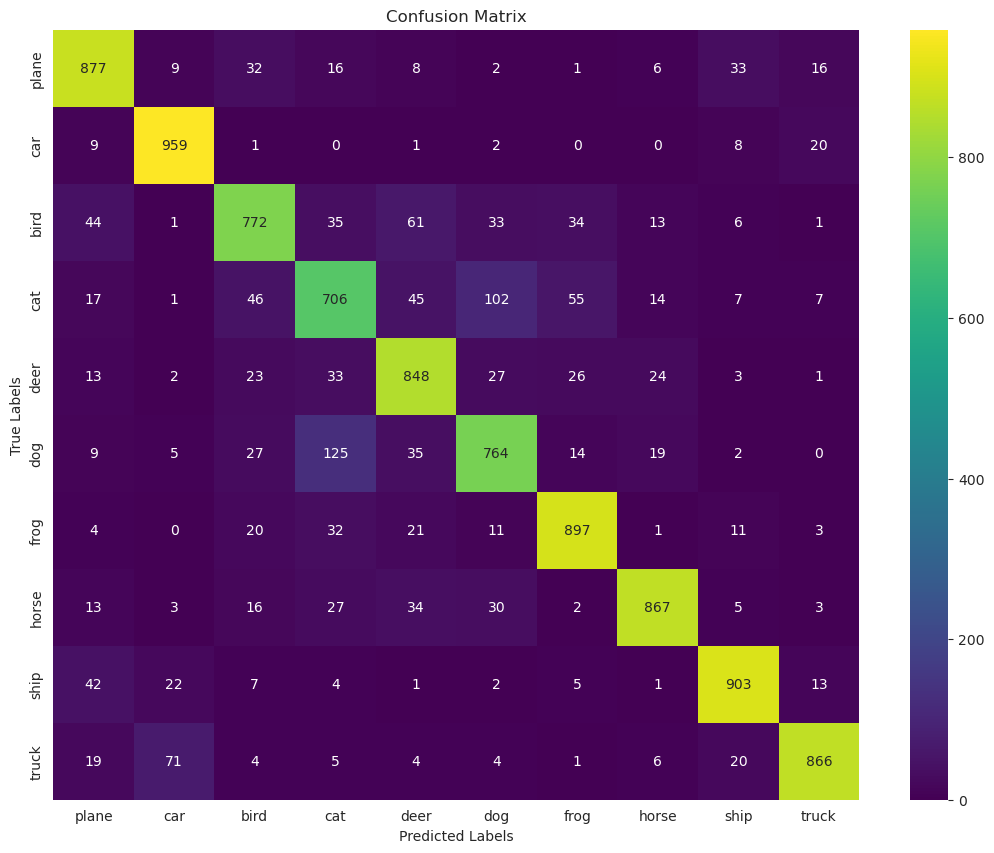

In [18]:
import utils as ut
ut.print_confusion_matrix(net5conv1,testset,classes)

In [16]:
trl = train_loss + train_loss2
tsl = test_loss + test_loss2
accl = acc + acc2

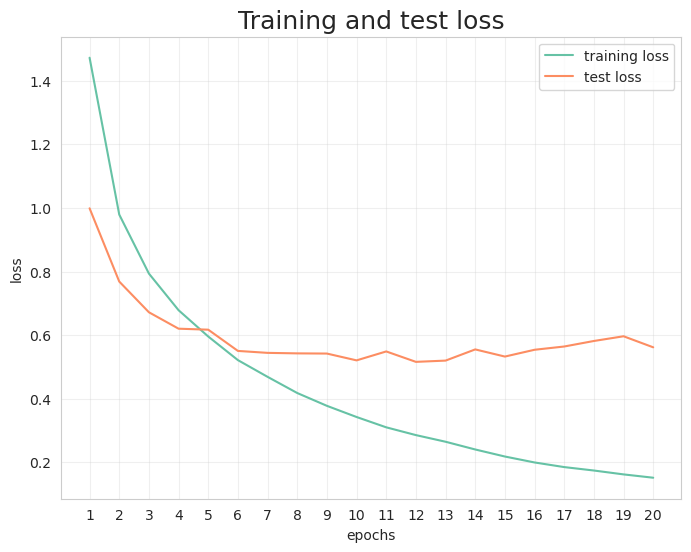

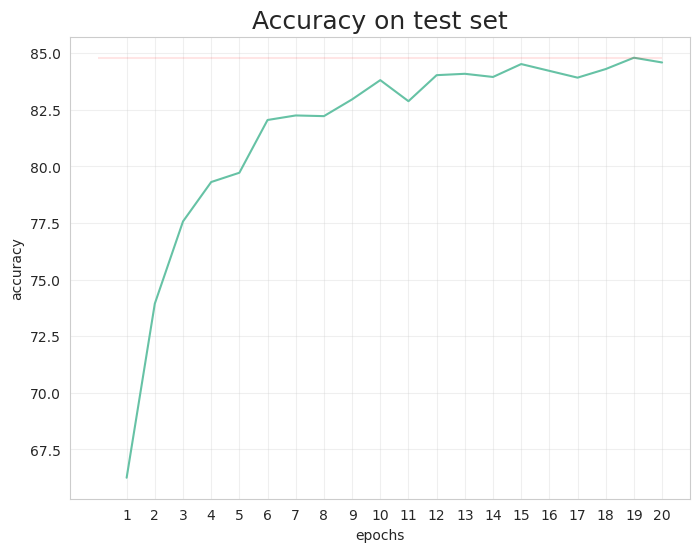

In [17]:
plot_losses (trl, tsl , accl )

In [ ]:
tsl5 = test_loss 
trl5 = train_loss 
accl5 = acc 
plot_losses(trl5,tsl5)
plt.figure(figsize=(10,8))
plt.title("Accuracy vs Epochs")
plt.plot(np.arange(len(accl5) ),accl5) 
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()
plt.show()


In [49]:
class ConvDeepNet(nn.Module):
    """
    This class defines a simple convolutional neural network (CNN) architecture
    for image classification.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer with 3 input channels (RGB),
                           6 output channels, and a kernel size of 5x5.
        pool (nn.MaxPool2d): Max pooling layer with a kernel size of 2x2.
        conv2 (nn.Conv2d): Second convolutional layer with 6 input channels
                           (from the first conv layer), 16 output channels,
                           and a kernel size of 5x5.
        fc1 (nn.Linear): First fully-connected layer that flattens the input
                         from the previous convolutional layers and has 120 neurons.
        fc2 (nn.Linear): Second fully-connected layer with 84 neurons.
        fc3 (nn.Linear): Output layer with 10 neurons, corresponding to the 10 classes
                         in CIFAR-10.

    Methods:
        forward(self, x): Defines the forward pass of the network.
    """
    
    
    def __init__(self):
        super(ConvDeepNet, self).__init__()  # Call the superclass constructor
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # First convolutional layer
        self.conv1b = nn.Conv2d(32, 64, 3, padding=1)  # First convolutional layer
        self.conv1c = nn.Conv2d(64, 64, 3, padding=1)  # First convolutional layer

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # Second convolutional layer
        self.conv2b = nn.Conv2d(128, 256, 3, padding=1)  # Second convolutional layer
        self.conv2c = nn.Conv2d(256, 256, 3, padding=1)  # Second convolutional layer
        
        self.conv3 = nn.Conv2d(256, 256, 3, padding=1)  # First convolutional layer
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)  # First convolutional layer
        self.conv3c = nn.Conv2d(256, 256, 3, padding=1)  # First convolutional layer

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)  # Second convolutional layer
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)  # Second convolutional layer
        self.conv4c = nn.Conv2d(512, 512, 3, padding=1)  # Second convolutional layer
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn1b = nn.BatchNorm2d(64)
        self.bn1c = nn.BatchNorm2d(64)
        
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(256)
        self.bn2c = nn.BatchNorm2d(256)
        
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
        self.bn3c = nn.BatchNorm2d(256)
        
       # self.bn4 = nn.BatchNorm2d(512)
        #self.bn4b = nn.BatchNorm2d(512)
        #self.bn4c = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        
        self.dropout1 = nn.Dropout(0.7)
        self.dropout2 = nn.Dropout(0.5)
        self.dropout3 = nn.Dropout(0.5)
        self.dropout4 = nn.Dropout(0.3)
  
    
        self.fc1 = nn.Linear(2048*2, 2048)  # First fully-connected layer
        self.fc2 = nn.Linear(2048, 1024)  # Second fully-connected layer
        self.fc3 = nn.Linear(1024, 1024)
        self.fc4 = nn.Linear(1024, 10)  # Output layer
   
    def forward(self, x):
        """"
        Defines the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor representing the images.

        Returns:
            torch.Tensor: Output tensor representing the class probabilities.
        """
        x = self.bn1(F.relu(self.conv1(x)) )
        x = self.bn1b(F.relu(self.conv1b(x)) )
        x = self.bn1c(F.relu(self.conv1c(x)) )
        
        x = self.pool(x)
        
        x = self.bn2(F.relu(self.conv2(x)) )
        x = self.bn2b(F.relu(self.conv2b(x)) )
        x = self.bn2c(F.relu(self.conv2c(x)) )
        
        x = self.pool(x)
        
        x = self.bn3(F.relu(self.conv3(x)) )
        x = self.bn3b(F.relu(self.conv3b(x)) )
        x = self.bn3c(F.relu(self.conv3c(x)) )
        
        x = self.pool(x)
        
        #x = self.bn4(F.relu(self.conv4(x)) )
        #x = self.bn4b(F.relu(self.conv4b(x)) )
        #x = self.bn4c(F.relu(self.conv4c(x)) )
       
       # x = self.pool(x)
        # print(x.shape)
       
        x = x.view(x.shape[0],-1)  # Flatten the output from convolutional layers
        # print(x.shape)
        x = self.dropout1(x)
        x = F.gelu(self.fc1(x))  # First fully-connected layer with ReLU activation
        x = self.dropout2(x)
        x = F.gelu(self.fc2(x))  # Second fully-connected layer with ReLU activation
        x=self.dropout3(x)
        x = F.gelu(self.fc3(x))
        #x=self.dropout4(x)
        x = self.fc4(x)  # Output layer
      
        return x
    

In [50]:
deepnet = ConvDeepNet()
deepnet.to(device)

summary(deepnet,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 256, 16, 16]         295,168
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]         590,080
      BatchNorm2d-13          [-1, 256, 16, 16]             512
        MaxPool2d-14            [-1, 25

In [52]:
deepnet1,train_loss ,test_loss, acc = lib.train_net(Net = deepnet, trainloader = trainloader, testloader = testloader,  learning_rate=0.001, momentum=0.9, epochs = 15, criterion = nn.CrossEntropyLoss(), verbose = True, bestmodel_name="deep_net")

[1,  2500] loss: 1.8911
[1,  5000] loss: 1.5992
[1,  7500] loss: 1.4273
[1, 10000] loss: 1.2920
[epoch: 1] train loss: 1.5524 test loss: 1.0042,test accuracy: 65.5 %
[2,  2500] loss: 1.1081
[2,  5000] loss: 1.0439
[2,  7500] loss: 1.0196
[2, 10000] loss: 0.9585
[epoch: 2] train loss: 1.0325 test loss: 0.8130,test accuracy: 73.3 %
[3,  2500] loss: 0.8634
[3,  5000] loss: 0.8476
[3,  7500] loss: 0.8378
[3, 10000] loss: 0.8092
[epoch: 3] train loss: 0.8395 test loss: 0.6921,test accuracy: 76.7 %
[4,  2500] loss: 0.7452
[4,  5000] loss: 0.7333
[4,  7500] loss: 0.7323
[4, 10000] loss: 0.7119
[epoch: 4] train loss: 0.7307 test loss: 0.6257,test accuracy: 79.4 %
[5,  2500] loss: 0.6385
[5,  5000] loss: 0.6532
[5,  7500] loss: 0.6271
[5, 10000] loss: 0.6431
[epoch: 5] train loss: 0.6405 test loss: 0.6062,test accuracy: 81.4 %
[6,  2500] loss: 0.5624
[6,  5000] loss: 0.5830
[6,  7500] loss: 0.5704
[6, 10000] loss: 0.5761
[epoch: 6] train loss: 0.5730 test loss: 0.5429,test accuracy: 82.4 %
[7, 

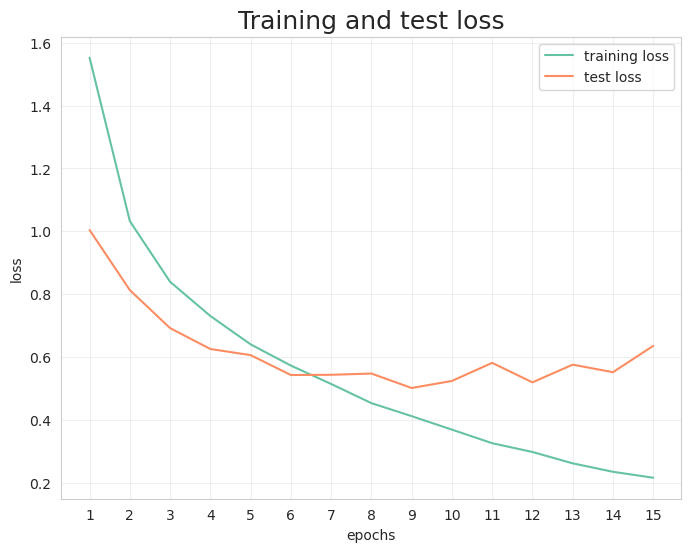

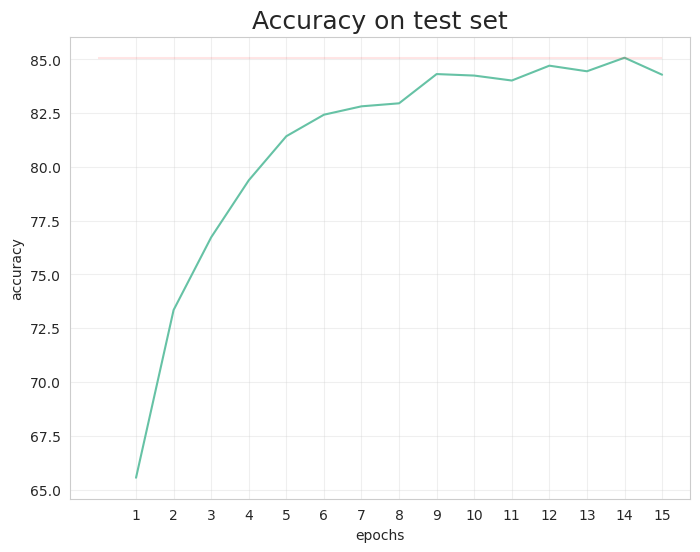

In [53]:
plot_losses(train_loss,test_loss, acc)

In [62]:
netbest = ConvDeepNet()
netbest.state_dict = torch.load("deep_net.pth")
netbest.to(device)
ut.print_confusion_matrix(netbest,testset,classes)

RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [26]:
deepnet1,train_loss2 ,test_loss2, acc2 = lib.train_net(Net = deepnet, trainloader = trainloader, testloader = testloader,  learning_rate=0.0005, momentum=0.9, epochs = 5, criterion = nn.CrossEntropyLoss(), verbose = True)

[1,  2500] loss: 0.2068
[1,  5000] loss: 0.2266
[1,  7500] loss: 0.2337
[1, 10000] loss: 0.2344
[epoch: 1] train loss: 0.2254 test loss: 0.5284,test accuracy: 84.6 %
[2,  2500] loss: 0.1620
[2,  5000] loss: 0.1833
[2,  7500] loss: 0.1865
[2, 10000] loss: 0.1933
[epoch: 2] train loss: 0.1813 test loss: 0.5906,test accuracy: 83.5 %
[3,  2500] loss: 0.1465
[3,  5000] loss: 0.1578
[3,  7500] loss: 0.1768
[3, 10000] loss: 0.1828
[epoch: 3] train loss: 0.1660 test loss: 0.6107,test accuracy: 83.4 %
[4,  2500] loss: 0.1194
[4,  5000] loss: 0.1394
[4,  7500] loss: 0.1450
[4, 10000] loss: 0.1614
[epoch: 4] train loss: 0.1413 test loss: 0.6179,test accuracy: 84.1 %
[5,  2500] loss: 0.1147
[5,  5000] loss: 0.1288
[5,  7500] loss: 0.1327
[5, 10000] loss: 0.1419
[epoch: 5] train loss: 0.1295 test loss: 0.8099,test accuracy: 81.7 %
Finished Training


In [27]:
trl = train_loss + train_loss2
tsl = test_loss + test_loss2
accl = acc  + acc2

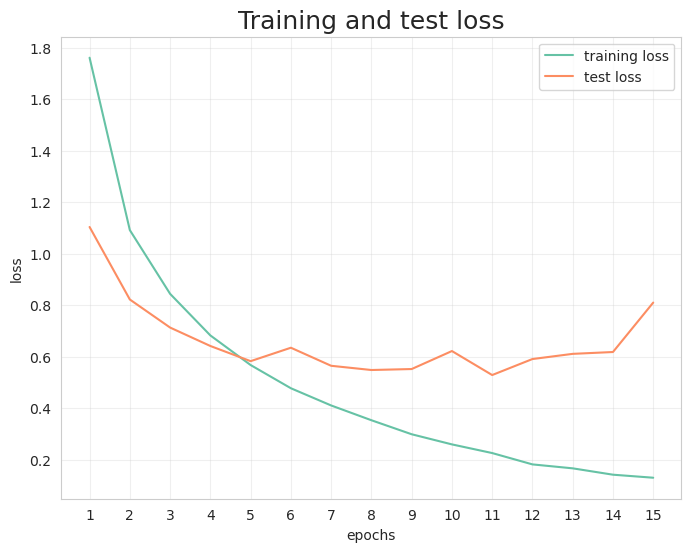

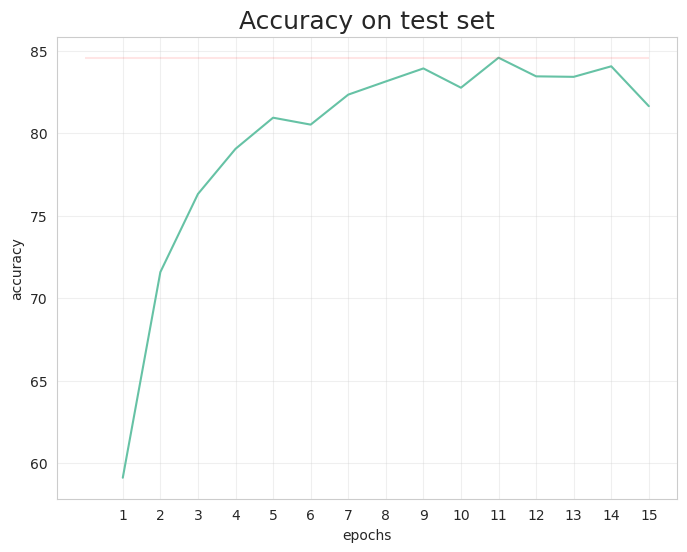

In [28]:
plot_losses(trl ,tsl,accl)

In [19]:
np.max(acc)

82.68

In [19]:
class ConvDeepNetNorm(nn.Module):
    """
    This class defines a simple convolutional neural network (CNN) architecture
    for image classification.

    Attributes:
        conv1 (nn.Conv2d): First convolutional layer with 3 input channels (RGB),
                           6 output channels, and a kernel size of 5x5.
        pool (nn.MaxPool2d): Max pooling layer with a kernel size of 2x2.
        conv2 (nn.Conv2d): Second convolutional layer with 6 input channels
                           (from the first conv layer), 16 output channels,
                           and a kernel size of 5x5.
        fc1 (nn.Linear): First fully-connected layer that flattens the input
                         from the previous convolutional layers and has 120 neurons.
        fc2 (nn.Linear): Second fully-connected layer with 84 neurons.
        fc3 (nn.Linear): Output layer with 10 neurons, corresponding to the 10 classes
                         in CIFAR-10.

    Methods:
        forward(self, x): Defines the forward pass of the network.
    """
    
    
    def __init__(self):
        super(ConvDeepNetNorm, self).__init__()  # Call the superclass constructor
        
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)  # First convolutional layer
        self.conv1b = nn.Conv2d(32, 64, 3, padding=1)  # First convolutional layer
        self.conv1c = nn.Conv2d(64, 64, 3, padding=1)  # First convolutional layer

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)  # Second convolutional layer
        self.conv2b = nn.Conv2d(128, 256, 3, padding=1)  # Second convolutional layer
        self.conv2c = nn.Conv2d(256, 256, 3, padding=1)  # Second convolutional layer
        
        self.conv3 = nn.Conv2d(256, 256, 3, padding=1)  # First convolutional layer
        self.conv3b = nn.Conv2d(256, 256, 3, padding=1)  # First convolutional layer
        self.conv3c = nn.Conv2d(256, 256, 3, padding=1)  # First convolutional layer

        self.conv4 = nn.Conv2d(256, 512, 3, padding=1)  # Second convolutional layer
        self.conv4b = nn.Conv2d(512, 512, 3, padding=1)  # Second convolutional layer
        self.conv4c = nn.Conv2d(512, 512, 3, padding=1)  # Second convolutional layer
        
        self.bn1 = nn.BatchNorm2d(32)
        self.bn1b = nn.BatchNorm2d(64)
        self.bn1c = nn.BatchNorm2d(64)
        
        self.bn2 = nn.BatchNorm2d(128)
        self.bn2b = nn.BatchNorm2d(256)
        self.bn2c = nn.BatchNorm2d(256)
        
        self.bn3 = nn.BatchNorm2d(256)
        self.bn3b = nn.BatchNorm2d(256)
        self.bn3c = nn.BatchNorm2d(256)
        
        self.bn4 = nn.BatchNorm2d(512)
        self.bn4b = nn.BatchNorm2d(512)
        self.bn4c = nn.BatchNorm2d(512)
        
        self.pool = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.dropout = nn.Dropout(0.5)
  
        self.fc1 = nn.Linear(2048, 256)  # First fully-connected layer
        self.fc2 = nn.Linear(256, 128)  # Second fully-connected layer
        self.fc3 = nn.Linear(128, 84)
        self.fc4 = nn.Linear(84, 10)  # Output layer
   
        self.bnf1 = nn.BatchNorm1d(256)
        self.bnf2 = nn.BatchNorm1d(128)
        self.bnf3 = nn.BatchNorm1d(84)
        
    def forward(self, x):
        """"
        Defines the forward pass of the neural network.

        Args:
            x (torch.Tensor): Input tensor representing the images.

        Returns:
            torch.Tensor: Output tensor representing the class probabilities.
        """
        x = self.bn1(F.relu(self.conv1(x)) )
        x = self.bn1b(F.relu(self.conv1b(x)) )
        x = self.bn1c(F.relu(self.conv1c(x)) )
        
        x = self.pool(x)
        
        x = self.bn2(F.relu(self.conv2(x)) )
        x = self.bn2b(F.relu(self.conv2b(x)) )
        x = self.bn2c(F.relu(self.conv2c(x)) )
        
        x = self.pool(x)
        
        x = self.bn3(F.relu(self.conv3(x)) )
        x = self.bn3b(F.relu(self.conv3b(x)) )
        x = self.bn3c(F.relu(self.conv3c(x)) )
        
        x = self.pool(x)
        
        x = self.bn4(F.relu(self.conv4(x)) )
        x = self.bn4b(F.relu(self.conv4b(x)) )
        x = self.bn4c(F.relu(self.conv4c(x)) )
       
        x = self.pool(x)
        # print(x.shape)
       
        x = x.view(x.shape[0],-1)  # Flatten the output from convolutional layers
        # print(x.shape)
        x = self.dropout(x)
        x = self.bnf1(F.gelu(self.fc1(x)) )
        x = self.dropout(x) 
        x = self.bnf2(F.gelu(self.fc2(x)) ) 
        x = self.dropout(x)
        x = self.bnf3(F.gelu(self.fc3(x)) )
        x = self.fc4(x)  # Output layer
      
        return x
    

In [20]:
deepnetnorm = ConvDeepNetNorm()
deepnetnorm.to(device)

summary(deepnetnorm,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 64, 32, 32]          18,496
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,928
       BatchNorm2d-6           [-1, 64, 32, 32]             128
         MaxPool2d-7           [-1, 64, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]          73,856
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 256, 16, 16]         295,168
      BatchNorm2d-11          [-1, 256, 16, 16]             512
           Conv2d-12          [-1, 256, 16, 16]         590,080
      BatchNorm2d-13          [-1, 256, 16, 16]             512
        MaxPool2d-14            [-1, 25

In [21]:
deepnetnorm1,train_loss ,test_loss, acc = lib.train_net(Net = deepnetnorm, trainloader = trainloader, testloader = testloader,  learning_rate=0.005, momentum=0.9, epochs = 10, criterion = nn.CrossEntropyLoss(), verbose = True)

[1,  2500] loss: 2.3387
[1,  5000] loss: 2.1879
[1,  7500] loss: 2.1225
[1, 10000] loss: 2.0749


KeyboardInterrupt: 